In [3]:
import pandas as pd
from oemof.solph import (EnergySystem, Bus, Sink, Source, Flow,
                         Transformer, GenericStorage)
from oemof.solph import views, processing
import matplotlib.pyplot as plt
import logging
from enum import Enum
import os
from os.path import join
import json
import warnings
from electricity_markets.market_price_generator import create_markets_info
import set_config
warnings.simplefilter(action='ignore', category=FutureWarning)
logging.basicConfig(level=logging.INFO)

INFO:root:DA Price pattern for the year 2019 created
INFO:root:ID Price pattern for the year 2019 created
INFO:root:Electricity market prices (DA,ID,FB,FP) for 2019 created


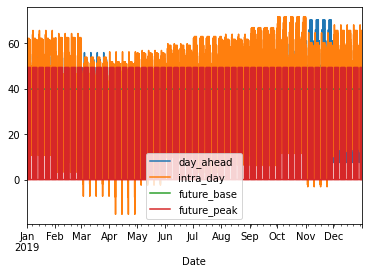

In [4]:
 # Get market data as per the price generator
year= 2019
days = 365
market_data = create_markets_info(
    year=year, save_csv=False,).head(
    days * 24 * 4)
market_data.plot()
from common import Districts
district = Districts.ENAQ
config = set_config.set_configuration(district= district)
district_name = district.value["name"]

In [11]:
# build the model
# since the models have all the same configuration, the naming of the labels will need to have a naming convention
# b = bus
# s = sink
# g = source/grid
#example
# b_th_enaq
label = district_name.lower()
def mlabel(txt):
    return f"{txt}_{label}"

energy_system = EnergySystem(timeindex=config["datetime"])

# first need a "general electric bus"
b_el_distr = Bus(label=mlabel("b_el_distr"))

# electric supply bus
b_d_el = Bus(label=mlabel("b_d_el"),
                inputs={b_el_distr: Flow()})

# this bus is to exchange energy with other districts:

b_el_exch = Bus(label=mlabel("b_el_exch"),
                inputs={b_el_distr: Flow()})

                 
# add district demands
d_el = Sink(label=mlabel("d_el"),
            inputs={
                b_d_el: Flow(
                    fix=config["el_demand"]["profile"],
                    nominal_value=1
                )})
energy_system.add(b_el_distr, b_d_el, b_el_exch, d_el)




In [12]:

# add heat bus and district demand
b_d_th = Bus(label=mlabel("b_d_th"))
# add district demands

b_th_distr = Bus(label=mlabel("b_th_distr"), outputs={b_d_th: Flow()})
s_th = Sink(label=mlabel("d_th"),
            inputs={
                b_d_th: Flow(
                    fix=config["heat_demand"]["profile"],
                    nominal_value=1
                )})
energy_system.add(b_d_th,b_th_distr,s_th)


In [13]:

# bus for selling electricity to the markets
# and the 4 markets

# this is the markets bus
b_el_market = Bus(label=mlabel("b_el_market"), 
                   inputs={b_el_distr: Flow()}
                    )

#Prices in EUR/kWh (need to divide by 4 since these are 15 mins intervals)
s_day_ahead = Sink(label=mlabel("s_da"),inputs={
            b_el_market: Flow(
                variable_costs=-
                market_data["day_ahead"]/1000/4)})

s_intraday = Sink(
    label=mlabel("s_id"),
    inputs={
        b_el_market: Flow(
            variable_costs=-
            market_data["intra_day"]/1000/4)})

s_f_base = Sink(
    label=mlabel("s_fb"),
    inputs={
        b_el_market: Flow(
            variable_costs=-
            market_data["future_base"]/1000/4)})

s_f_peak = Sink(
    label=mlabel("s_fp"),
    inputs={
        b_el_market: Flow(
            variable_costs=-
            market_data["future_peak"]/1000/4)})

energy_system.add(b_el_market, s_day_ahead, s_intraday, s_f_base,s_f_peak)


In [ ]:
# Add the external energy sources and related buses

# external gas
b_gas = Bus(label=mlabel("b_gas"))
energy_system.add(b_gas)

if "gas" in config.keys():
    GAS_PRICE = 3.66  # EUR per mmBTU
    # EUR/mmBTU / (293.07 kWh/mmBTU)
    GAS_PRICE = GAS_PRICE / 293.07
  
    s_gas = Source(
        label=mlabel('m_gas'),
        outputs={
            b_gas: Flow(
                variable_costs=GAS_PRICE)})  # EUR/kWh

    energy_system.add(s_gas)

b_ext_th = Bus(label=mlabel("b_ext_th"))
energy_system.add(b_ext_th)
if "ext_grid" in config.keys():
    s_ext_th = Source(
        label=mlabel('s_ext_th'),
        outputs={b_ext_th: Flow()})  # EUR/kWh
    energy_system.add(s_ext_th)

b_el_grid = Bus(label=mlabel("b_el_grid"), outputs={b_el_distr: Flow()})
s_el_grid = Source(
    label=mlabel("s_el_grid"),
    outputs={b_el_grid: Flow(
        variable_costs=1000000)})  # EUR/kWh

energy_system.add(b_el_grid,s_el_grid)


In [ ]:
# add renewable energy buses and technologies

b_el_renew = Bus(label=mlabel("b_el_renew"))
energy_system.add(b_el_renew)
if "PV" in config.keys():
    s_pv = Source(
        label=mlabel("s_pv"),
        outputs={
            b_el_renew: Flow(
                nominal_value=1,
                max=config["PV"]["profile"])})
    energy_system.add(s_pv)

if "Wind" in config.keys():
    s_wind = Source(
            label=mlabel("s_wind"),
            outputs={
                b_el_renew: Flow(
                    nominal_value=1,
                    max=config["Wind"]["profile"])})
    energy_system.add(s_wind)

b_th_renew = Bus(label=mlabel("b_th_renew"))
energy_system.add(b_th_renew)

if "ST" in config.keys():
    s_st = Source(
            label=mlabel("s_st"),
            outputs={
                b_el_renew: Flow(
                    nominal_value=1,
                    max=config["ST"]["profile"])})
    energy_system.add(s_st)


In [ ]:
# add combination technologies, like CHP
b_el_prod = Bus(label=mlabel("b_el_prod"), inputs={b_el_renew: Flow()}, outputs={b_el_distr: Flow()})
b_th_prod = Bus(label=mlabel("b_th_prod"),inputs={b_th_renew: Flow()}, outputs={b_th_distr: Flow()})
energy_system.add(b_el_prod,b_th_prod)
#add a boiler
if "boiler" in config.keys():
    t_boiler = Transformer(
        label=mlabel('t_boiler'),
        inputs={b_gas: Flow()},
        outputs={
            b_th_prod: Flow(nominal_value=config["boiler"]["p_kw"])},
        conversion_factors={
            b_gas: 1,
            b_th_prod: config["boiler"]["eff"] })
    energy_system.add(t_boiler)

if "chp" in config.keys():
    t_chp = Transformer(
        label='t_chp',
        inputs={b_gas: Flow()},
        outputs={
            b_el_prod: Flow(nominal_value=config["chp"]["p_kw_el"]),
            b_th_prod: Flow(nominal_value=config["chp"]["p_kw_th"])},
        conversion_factors={
            b_el_prod: config["chp"]["eff_el"],
            b_th_prod: config["chp"]["eff_th"]})
    energy_system.add(t_chp)


In [ ]:
if "heat_pump" in config.keys():
    t_hp = Transformer(
        label=mlabel('t_hp'),
        inputs={b_el_prod: Flow()},
        outputs={b_th_prod: Flow(nominal_value=config["heat_pump"]["p_kw_th"])},
        conversion_factors={b_th_prod: config["heat_pump"]["cop"]})
    energy_system.add(t_hp)


dict_keys(['name', 'datetime', 'gas', 'boiler', 'heat_pump', 'heat_demand', 'PV', 'ST', 'Wind', 'el_demand', 'chp', 'electrolizer', 'heat_sto', 'batt_sto'])

{'capacity': 250.0,
 'charge_cap': 200.0,
 'discharge_cap': 200.0,
 'charge_eff': 0.8625945649131268,
 'disch_eff': 0.8587555559635626,
 'loss_rate': 0.01}

In [ ]:
# att electric storage
if "batt_sto" in config.keys():
    batt_sto = GenericStorage(
        label=mlabel('sto_batt'),
        inputs={
            b_el_prod: Flow(nominal_value=config["batt_sto"]["charge_cap"])},
        outputs={
            b_el_prod: Flow(nominal_value=config["batt_sto"]["discharge_cap"])},
        loss_rate=config["batt_sto"]["loss_rate"],
        nominal_storage_capacity=config["batt_sto"]["capacity"],
        inflow_conversion_factor=config["batt_sto"]["charge_eff"],
        outflow_conversion_factor=config["batt_sto"]["disch_eff"],
        initial_storage_level=0,
        balanced=False)
    energy_system.add(batt_sto)




In [ ]:
# This needs to be fixed to work with volumes and heat insulation properties
# Will find a better formulation later
bus_th_distr =  Bus(label=mlabel("b_th_distr"), inputs={b_th_prod: Flow(),b_ext_th: Flow() }, outputs={b_d_th: Flow()})
energy_system.add(bus_th_distr)
if "heat_sto" in config.keys():
    heat_sto = GenericStorage(
        label=mlabel('sto_heat'),
        inputs={
            bus_th_distr: Flow(nominal_value=config["heat_sto"]["charge_cap"])},
        outputs={
            bus_th_distr: Flow(nominal_value=config["heat_sto"]["discharge_cap"])},
        loss_rate=config["heat_sto"]["loss_rate"],
        nominal_storage_capacity=config["heat_sto"]["capacity"],
        inflow_conversion_factor=config["heat_sto"]["charge_eff"],
        outflow_conversion_factor=config["heat_sto"]["disch_eff"],
        initial_storage_level=0,
        balanced=False)
    energy_system.add(heat_sto)



In [ ]:
'''
Build a pyomo Model and add constraints for the proper sinks
:param energy_system: Energy System with the appropiate markets.
'''
# Build model
from oemof.solph import Model
import pyomo.environ as po

model = Model(energy_system)


ERROR:pyomo.core:Constructing component 'Bus.balance_build' from data=None failed:
KeyError: 'Index \'("<oemof.solph.network.bus.Bus: \'b_d_distr_enaq\'>", "<oemof.solph.network.bus.Bus: \'b_d_th_enaq\'>", 0)\' is not valid for indexed component \'flow\''


ERROR: Constructing component 'Bus.balance_build' from data=None failed:
    KeyError: 'Index \'("<oemof.solph.network.bus.Bus: \'b_d_distr_enaq\'>",
    "<oemof.solph.network.bus.Bus: \'b_d_th_enaq\'>", 0)\' is not valid for
    indexed component \'flow\''


KeyError: 'Index \'("<oemof.solph.network.bus.Bus: \'b_d_distr_enaq\'>", "<oemof.solph.network.bus.Bus: \'b_d_th_enaq\'>", 0)\' is not valid for indexed component \'flow\''

In [ ]:

# Before anything I need the shape of the future_peak in the shape of 1
# and 0

# electric bus
bus_el_out = [n for n in energy_system.nodes if n.label == label("b_el_market")][0]
# check output
key = [k for k in bus_el_out.outputs.keys() if "s_fp" in str(k)][0]
future_base_flow_price = bus_el_out.outputs[key].variable_costs

# Add Market Constraints

# Constraint for the Day Ahead Market
# i = inflow
# o = outflow
flows = {}
for (i, o) in model.flows:
    if str(i) == label("b_el_market") and str(o) == "s_da":
        flows[(i, o)] = model.flows[i, o]

for (i, o) in flows:
    for t in model.TIMESTEPS:
        if t % 4 != 0:
            # ToDo: Change name to day_ahead
            limit_name = "day_ahead_{}={}".format(t, t - t % 4)
            setattr(model, limit_name, po.Constraint(
                rule=(model.flow[i, o, t] - model.flow[i, o, t - t % 4] == 0)))

# Constraint for the Future Peak
flows = {}

for (i, o) in model.flows:
    if str(i) == label("b_el_market") and str(o) == "s_fb":
        flows[(i, o)] = model.flows[i, o]

for (i, o) in flows:
    for t in model.TIMESTEPS:
        if t != 0:
            limit_name = "future_base_{}={}".format(t, 0)
            setattr(model, limit_name, po.Constraint(
                rule=(model.flow[i, o, t] - model.flow[i, o, 0] == 0)))

# Constraint for the Future Base
# what are the time steps for decision making?
# I rather look at the shape of the cost of the flow to see
# if the price is 0, then constraint is 0
# if price is not 0, then the price is equal

flows = {}
for (i, o) in model.flows:
    if str(i) == label("b_el_market") and str(o) == "s_fp":
        flows[(i, o)] = model.flows[i, o]

times_future_base_constraint = [t for t in model.TIMESTEPS if abs(
    future_base_flow_price[t]) > 0.001]  # a small tolerance there

for time_step in times_future_base_constraint[1:]:  # for each day
    # range = 12*4 #time steps for the constraint, 13 hrs after 8 am, until
    # 20:45
    # the last bit of the 13h is not included
    t0 = times_future_base_constraint[0]
    for (i, o) in flows:
        limit_name = "future_peak_{}={}".format(time_step, t0)
        setattr(model, limit_name, po.Constraint(
            rule=(model.flow[i, o, t0] - model.flow[i, o, time_step] == 0)))

times_fb_null = [
    t for t in model.TIMESTEPS if t not in times_future_base_constraint]
for t in times_fb_null:
    limit_name = "future_peak_null_{}".format(t)
    setattr(
        model,
        limit_name,
        po.Constraint(
            rule=(
                model.flow[i, o, t] == 0)))